In [2]:
import pandas as pd

copi_complex_df = pd.read_csv(r"../data/LRBAandSNARE/heklopit_pl3017_frd1ppi_sc151_fdr1rp_LRBAandSNARE.csv")
copi_complex_df.head()

,protein_a,protein_b,gene_a,gene_b,Alpha protein(s) position(s),Beta protein(s) position(s),pepA,pepB,Score,Software
0,O15400,O15400,STX7,STX7,106,116,LVAEFTTSLTNFQ[K]VQR,E[K]EFVAR,0.998971,Plink3
1,O15400,O15400,STX7,STX7,138,116,VSGSFPEDSS[K]ER,E[K]EFVAR,0.999884,Plink3
2,O15400,O15400,STX7,STX7,55,138,QQLQQ[K]QQYTNQLAK,VSGSFPEDSS[K]ER,0.999992,Plink3
3,O15400,O15400,STX7,STX7,138,68,VSGSFPEDSS[K]ER,ETD[K]YIK,0.963087,Plink3
4,O15400,O15400,STX7,STX7,24,55,ISSNIQ[K]ITQCSVEIQR,QQLQQ[K]QQYTNQLAK,1.000000,Plink3


In [ ]:
# 迭代每一行，如果有；分开的，先删除，降低复杂度


In [3]:
from Bio import SeqIO

copi_fasta_path = r"../data/LRBAandSNARE/LRBAandSNARE.fasta"

copi_seqs_dict = {}
with open(copi_fasta_path) as handle:
    for record in SeqIO.parse(handle, "fasta"):
        protein_id = str(record.id).split("|")[1]
        seq = str(record.seq)
        copi_seqs_dict[protein_id] = seq

copi_seqs_dict


{'O15400': 'MSYTPGVGGDPAQLAQRISSNIQKITQCSVEIQRTLNQLGTPQDSPELRQQLQQKQQYTNQLAKETDKYIKEFGSLPTTPSEQRQRKIQKDRLVAEFTTSLTNFQKVQRQAAEREKEFVARVRASSRVSGSFPEDSSKERNLVSWESQTQPQVQVQDEEITEDDLRLIHERESSIRQLEADIMDINEIFKDLGMMIHEQGDVIDSIEANVENAEVHVQQANQQLSRAADYQRKSRKTLCIIILILVIGVAIISLIIWGLNH',
 'P50851': 'MASEDNRVPSPPPTGDDGGGGGREETPTEGGALSLKPGLPIRGIRMKFAVLTGLVEVGEVSNRDIVETVFNLLVGGQFDLEMNFIIQEGESINCMVDLLEKCDITCQAEVWSMFTAILKKSIRNLQVCTEVGLVEKVLGKIEKVDNMIADLLVDMLGVLASYNLTVRELKLFFSKLQGDKGRWPPHAGKLLSVLKHMPQKYGPDAFFNFPGKSAAAIALPPIAKWPYQNGFTFHTWLRMDPVNNINVDKDKPYLYCFRTSKGLGYSAHFVGGCLIVTSIKSKGKGFQHCVKFDFKPQKWYMVTIVHIYNRWKNSELRCYVNGELASYGEITWFVNTSDTFDKCFLGSSETADANRVFCGQMTAVYLFSEALNAAQIFAIYQLGLGYKGTFKFKAESDLFLAEHHKLLLYDGKLSSAIAFTYNPRATDAQLCLESSPKDNPSIFVHSPHALMLQDVKAVLTHSIQSAMHSIGGVQVLFPLFAQLDYRQYLSDEIDLTICSTLLAFIMELLKNSIAMQEQMLACKGFLVIGYSLEKSSKSHVSRAVLELCLAFSKYLSNLQNGMPLLKQLCDHVLLNPAIWIHTPAKVQLMLYTYLSTEFIGTVNIYNTIRRVGTVLLIMHTLKYYYWAVNPQDRSGITPKGLDGPRPNQKEMLSLRAFLLMFIKQLVMKDSGVKEDELQAILNYLLTMHEDDNLMDVLQLLVALMSEHPNSMI

In [5]:
def find_bracket_k_position(peptide, protein):
    import re

    # 去除 peptide 中所有空格
    pep_no_space = peptide.replace(" ", "")
    
    if "[K]" not in pep_no_space:
        print(pep_no_space)

    # 找到 [X] 的位置
    m = re.search(r"\[([A-Z])\]", pep_no_space)
    if not m:
        raise ValueError("Peptide does not contain bracketed amino acid like [K]")

    aa = m.group(1)                 # 被括号包含的氨基酸，例如 K
    aa_index_in_pep = m.start()     # '[' 在无空格序列中的位置（0-based）

    # 去除方括号得到真实肽序列
    clean_pep = re.sub(r"\[([A-Z])\]", r"\1", pep_no_space)

    # 在蛋白中查找肽段
    start = protein.find(clean_pep)
    if start == -1:
        print("Peptide not found in protein:", peptide)
        return None

    # 计算氨基酸在蛋白中的位置（0-based）
    aa_pos_0 = start + aa_index_in_pep

    # 返回 1-based
    return aa_pos_0 + 1


# find_bracket_k_position("AAAQCYIDLII[K]ESDNNVK",copi_seqs_dict["P53618"])

In [8]:
json_files = {}
for index,row in copi_complex_df.iterrows():
    try:
        if f"{row[0]}_{row[1]}" in json_files.keys():
            crosslink_residue_pair = [
                    [[str(row[2]), find_bracket_k_position(row["pepA"],copi_seqs_dict[row["protein_a"]])],
                    [str(row[3]), find_bracket_k_position(row["pepB"],copi_seqs_dict[row["protein_b"]])]]
                    ]
            json_files[f"{row[0]}_{row[1]}"]["crosslinks"][0]["residue_pairs"].append(crosslink_residue_pair)
            # break
        elif f"{row[1]}_{row[0]}" in json_files.keys():
            crosslink_residue_pair = [
                    [
                    [str(row[3]), find_bracket_k_position(row["pepB"],copi_seqs_dict[row["protein_b"]])]],
                    [str(row[2]), find_bracket_k_position(row["pepA"],copi_seqs_dict[row["protein_a"]])]
                    ]
            json_files[f"{row[1]}_{row[0]}"]["crosslinks"][0]["residue_pairs"].append(crosslink_residue_pair)
        else:
            json_files[f"{row[0]}_{row[1]}"] = {}
            json_files[f"{row[0]}_{row[1]}"]["name"] = f"{row[0]}_{row[1]}"
            json_files[f"{row[0]}_{row[1]}"]["modelSeeds"] = [1]

            protein_a = {"id":str(row[2]),
                        "sequence":str(copi_seqs_dict[row[0]])}
            protein_b = {"id":str(row[3]),
                        "sequence":str(copi_seqs_dict[row[1]])}
            json_files[f"{row[0]}_{row[1]}"]["sequences"] = [protein_a,protein_b]
            json_files[f"{row[0]}_{row[1]}"]["dialect"] = "alphafold3"
            json_files[f"{row[0]}_{row[1]}"]["version"] = 1

            json_files[f"{row[0]}_{row[1]}"]["crosslinks"] = [{
                "name": "azide-A-DSBSO",
                "residue_pairs":[
                    [[str(row[2]), find_bracket_k_position(row["pepA"],copi_seqs_dict[row["protein_a"]])],
                    [str(row[3]), find_bracket_k_position(row["pepB"],copi_seqs_dict[row["protein_b"]])]]
                    ]
            }]

    except:
        # print(row)
        pass
    

json_files

C:\Users\zhang.zehong\AppData\Local\Temp\ipykernel_30320\1684711736.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if f"{row[0]}_{row[1]}" in json_files.keys():
C:\Users\zhang.zehong\AppData\Local\Temp\ipykernel_30320\1684711736.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif f"{row[1]}_{row[0]}" in json_files.keys():
C:\Users\zhang.zehong\AppData\Local\Temp\ipykernel_30320\1684711736.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, us

{'O15400_O15400': {'name': 'O15400_O15400',
  'modelSeeds': [1],
  'sequences': [{'id': 'STX7',
    'sequence': 'MSYTPGVGGDPAQLAQRISSNIQKITQCSVEIQRTLNQLGTPQDSPELRQQLQQKQQYTNQLAKETDKYIKEFGSLPTTPSEQRQRKIQKDRLVAEFTTSLTNFQKVQRQAAEREKEFVARVRASSRVSGSFPEDSSKERNLVSWESQTQPQVQVQDEEITEDDLRLIHERESSIRQLEADIMDINEIFKDLGMMIHEQGDVIDSIEANVENAEVHVQQANQQLSRAADYQRKSRKTLCIIILILVIGVAIISLIIWGLNH'},
   {'id': 'STX7',
    'sequence': 'MSYTPGVGGDPAQLAQRISSNIQKITQCSVEIQRTLNQLGTPQDSPELRQQLQQKQQYTNQLAKETDKYIKEFGSLPTTPSEQRQRKIQKDRLVAEFTTSLTNFQKVQRQAAEREKEFVARVRASSRVSGSFPEDSSKERNLVSWESQTQPQVQVQDEEITEDDLRLIHERESSIRQLEADIMDINEIFKDLGMMIHEQGDVIDSIEANVENAEVHVQQANQQLSRAADYQRKSRKTLCIIILILVIGVAIISLIIWGLNH'}],
  'dialect': 'alphafold3',
  'version': 1,
  'crosslinks': [{'name': 'azide-A-DSBSO',
    'residue_pairs': [[['STX7', 106], ['STX7', 116]],
     [[['STX7', 138], ['STX7', 116]]],
     [[['STX7', 55], ['STX7', 138]]],
     [[['STX7', 138], ['STX7', 68]]],
     [[['STX7', 24], ['STX7', 55]]],
     [[['STX7', 24], ['STX7',

In [9]:
json_files = {}

def build_residue_pair(row, A_first=True):
    """生成 residue_pairs，自动处理 A/B 方向"""
    if A_first:
        return [
            ["A", find_bracket_k_position(row["pepA"], copi_seqs_dict[row["protein_a"]])],
            ["B", find_bracket_k_position(row["pepB"], copi_seqs_dict[row["protein_b"]])]
        ]
    else:
        return [
            ["A", find_bracket_k_position(row["pepB"], copi_seqs_dict[row["protein_b"]])],
            ["B", find_bracket_k_position(row["pepA"], copi_seqs_dict[row["protein_a"]])]
        ]

for _, row in copi_complex_df.iterrows():
    try:
        key_direct = f"{row[2]}_{row[3]}"
        key_reverse = f"{row[3]}_{row[2]}"
        # 添加inter-links
        if key_direct != key_reverse:

            # 判断 key 方向
            if key_direct in json_files:
                key = key_direct
                A_first = True
            elif key_reverse in json_files:
                key = key_reverse
                A_first = False
            else:
                # 创建新 entry
                key = key_direct
                json_files[key] = {
                    "name": key,
                    "modelSeeds": [1],
                    "sequences": [
                        {"protein":{"id": "A", "sequence": str(copi_seqs_dict[row[0]])}},
                        {"protein":{"id": "B", "sequence": str(copi_seqs_dict[row[1]])}}
                    ],
                    "dialect": "alphafold3",
                    "version": 1,
                    "crosslinks": [{
                        "name": "azide-A-DSBSO",
                        "residue_pairs": []
                    }]
                }
                A_first = True

            # 追加 residue pair
            residue_pair = build_residue_pair(row, A_first)
            json_files[key]["crosslinks"][0]["residue_pairs"].append(residue_pair)

    except Exception as e:
        print(row["gene_a"],row["gene_b"])
        # print("Error:", e)  # 建议保留错误信息，不要 pass

json_files


C:\Users\zhang.zehong\AppData\Local\Temp\ipykernel_30320\1991687914.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key_direct = f"{row[2]}_{row[3]}"
C:\Users\zhang.zehong\AppData\Local\Temp\ipykernel_30320\1991687914.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key_reverse = f"{row[3]}_{row[2]}"
C:\Users\zhang.zehong\AppData\Local\Temp\ipykernel_30320\1991687914.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  {"pr

{'STX7_LRBA': {'name': 'STX7_LRBA',
  'modelSeeds': [1],
  'sequences': [{'protein': {'id': 'A',
     'sequence': 'MSYTPGVGGDPAQLAQRISSNIQKITQCSVEIQRTLNQLGTPQDSPELRQQLQQKQQYTNQLAKETDKYIKEFGSLPTTPSEQRQRKIQKDRLVAEFTTSLTNFQKVQRQAAEREKEFVARVRASSRVSGSFPEDSSKERNLVSWESQTQPQVQVQDEEITEDDLRLIHERESSIRQLEADIMDINEIFKDLGMMIHEQGDVIDSIEANVENAEVHVQQANQQLSRAADYQRKSRKTLCIIILILVIGVAIISLIIWGLNH'}},
   {'protein': {'id': 'B',
     'sequence': 'MASEDNRVPSPPPTGDDGGGGGREETPTEGGALSLKPGLPIRGIRMKFAVLTGLVEVGEVSNRDIVETVFNLLVGGQFDLEMNFIIQEGESINCMVDLLEKCDITCQAEVWSMFTAILKKSIRNLQVCTEVGLVEKVLGKIEKVDNMIADLLVDMLGVLASYNLTVRELKLFFSKLQGDKGRWPPHAGKLLSVLKHMPQKYGPDAFFNFPGKSAAAIALPPIAKWPYQNGFTFHTWLRMDPVNNINVDKDKPYLYCFRTSKGLGYSAHFVGGCLIVTSIKSKGKGFQHCVKFDFKPQKWYMVTIVHIYNRWKNSELRCYVNGELASYGEITWFVNTSDTFDKCFLGSSETADANRVFCGQMTAVYLFSEALNAAQIFAIYQLGLGYKGTFKFKAESDLFLAEHHKLLLYDGKLSSAIAFTYNPRATDAQLCLESSPKDNPSIFVHSPHALMLQDVKAVLTHSIQSAMHSIGGVQVLFPLFAQLDYRQYLSDEIDLTICSTLLAFIMELLKNSIAMQEQMLACKGFLVIGYSLEKSSKSHVSRAVLELCLAFSKYLSNLQNGMPLLKQLCDHVLL

In [7]:
import json
for key in json_files.keys():
    file_name = f"../data/LRBAandSNARE/jsons/{key}.json"
    data = json_files[key]
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

1. 两两进行预测，取有最多复合物相差最小的单体作为模板。再用该模板将所有相关复合物预测一遍
2. 最终进行全面拼装组合
3. 对力场进行微调，更加符合真实结构，解决冲突

In [ ]:
# mpDockQ:
# TODO:后续需要加入符合条件的interaction打分（乘一个数值，该数值为符合crosslinker的长度的num/总crosslinker num）
# 参考https://github.com/patrickbryant1/MoLPC/blob/master/src/complex_assembly/mcts.py
import numpy as np

def score_complex(path_coords, path_CB_inds, path_plddt):
    '''Score all interfaces in the current complex
    '''

    complex_score = 0
    chain_inds = np.arange(len(path_coords))
    #Get interfaces per chain
    for i in chain_inds:
        chain_coords = path_coords[i]
        chain_CB_inds = path_CB_inds[i]
        l1 = len(chain_CB_inds)
        chain_CB_coords = chain_coords[chain_CB_inds]
        chain_plddt = path_plddt[i]

        for int_i in np.setdiff1d(chain_inds, i):
            int_chain_CB_coords = path_coords[int_i][path_CB_inds[int_i]]
            int_chain_plddt = path_plddt[int_i]
            #Calc 2-norm
            mat = np.append(chain_CB_coords,int_chain_CB_coords,axis=0)
            a_min_b = mat[:,np.newaxis,:] -mat[np.newaxis,:,:]
            dists = np.sqrt(np.sum(a_min_b.T ** 2, axis=0)).T
            contact_dists = dists[:l1,l1:]
            contacts = np.argwhere(contact_dists<=8)
            #The first axis contains the contacts from chain 1
            #The second the contacts from chain 2
            if contacts.shape[0]>0:
                av_if_plDDT =  np.concatenate((chain_plddt[contacts[:,0]], int_chain_plddt[contacts[:,1]])).mean()
                complex_score +=  np.log10(contacts.shape[0]+1)*av_if_plDDT
    
    return complex_score

In [ ]:
# 新版流程

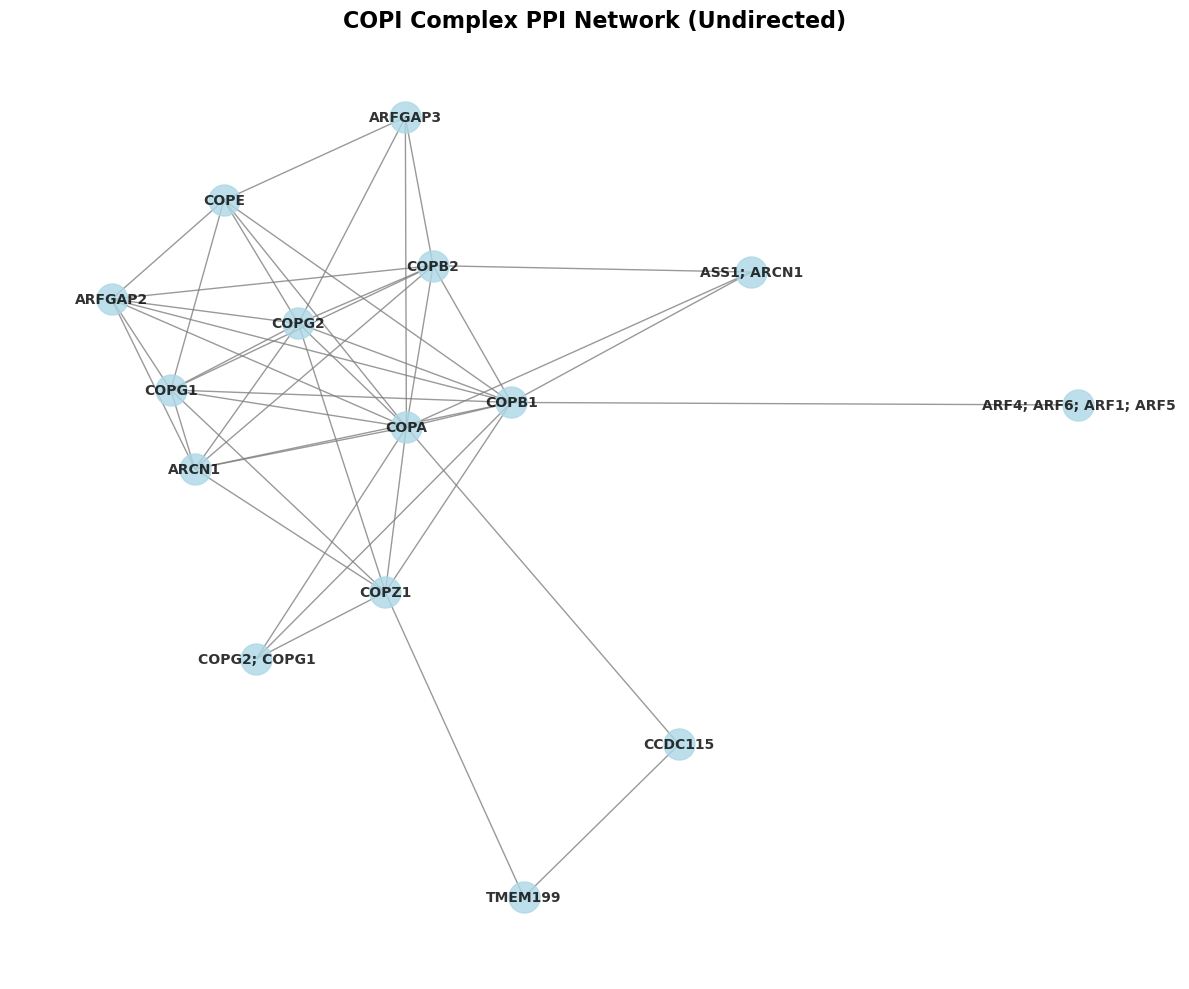

['ASS1; ARCN1', 'COPG2; COPG1', 'ARF4; ARF6; ARF1; ARF5']


In [ ]:
# 构建相互作用图，从crosslink data中
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

xl_df = pd.read_csv(r"N:\08_NK_structure_prediction\data\COPI_complex\heklopit_pl3017_frd1ppi_sc151_fdr1rp_COPI.csv")
xl_df.head()


G = nx.Graph()
for index, row in xl_df.iterrows():
    # 分割蛋白质列表（如果有多个蛋白质用分号分隔）
    proteins_a = [p.strip() for p in str(row["gene_a"]).split(";")]
    proteins_b = [p.strip() for p in str(row["gene_b"]).split(";")]
    
    # 检查是否有交集（即是否有相同的蛋白质）
    # 如果有交集，说明是自环或内部连接，跳过
    if set(proteins_a) & set(proteins_b):
        continue  # 跳过这一行，不添加边
    
    # 如果没有交集，添加边
    G.add_edge(row["gene_a"], row["gene_b"])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, 
                 pos=pos,
                 with_labels=True,
                 node_size=500,
                 node_color='lightblue',
                 edge_color='gray',
                 font_size=10,
                 font_weight='bold',
                 width=1.0,
                 alpha=0.8)

plt.title("COPI Complex PPI Network (Undirected)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# 显示图中仍带有;符号的节点名，修改节点名
print([prot for prot in G.nodes() if ";" in prot])

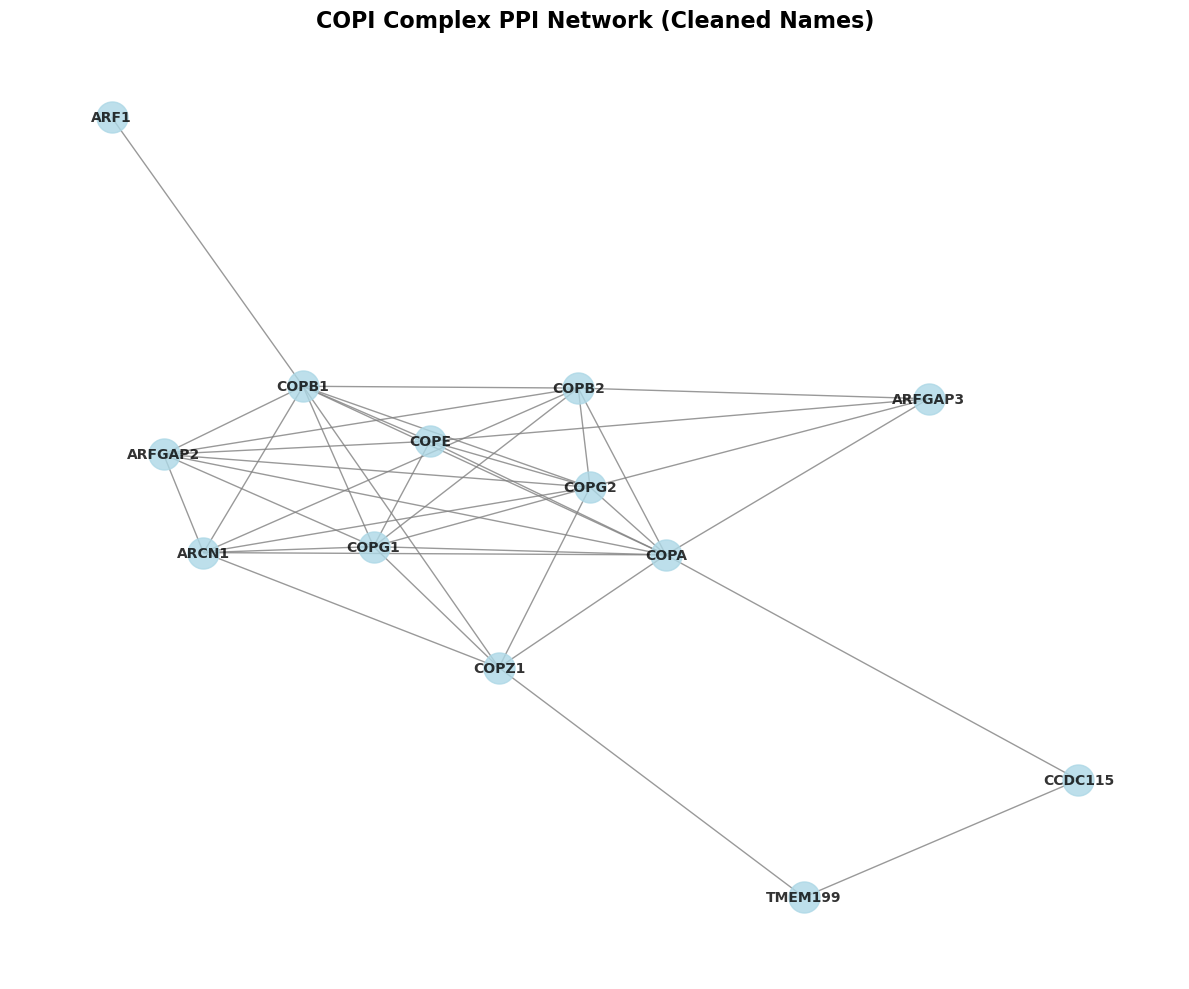

In [16]:
# 人工设置多蛋白到单蛋白映射
single_prot_map = {
    'ASS1; ARCN1':'ARCN1', 
    'COPG2; COPG1':'COPG1',  # g1z1
    'ARF4; ARF6; ARF1; ARF5':'ARF1'
}

# 创建重命名映射
rename_dict = {}
for node in G.nodes():
    # 如果在映射字典中，就替换
    if node in single_prot_map:
        rename_dict[node] = single_prot_map[node]
    # 否则保留原样
    else:
        # 可以添加更多清理逻辑，比如如果有分号，取第一个
        if ";" in str(node):
            rename_dict[node] = str(node).split(";")[0].strip()

# 重命名节点
G = nx.relabel_nodes(G, rename_dict)

# 绘制图形
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, 
                 pos=pos,
                 with_labels=True,
                 node_size=500,
                 node_color='lightblue',
                 edge_color='gray',
                 font_size=10,
                 font_weight='bold',
                 width=1.0,
                 alpha=0.8)

plt.title("COPI Complex PPI Network (Cleaned Names)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# 从protein_list中抽取三个，如果在相互作用图中没有连接，则舍去该三元组
from itertools import combinations

protein_list = ['COPB1',
 'COPB2',
 'ARCN1',
 'ARFGAP2',
 'COPA',
#  'COPG2', # g1z1
 'COPZ1',
 'COPG1',
 'COPE',
 'ARFGAP3',
 'CCDC115',
 'TMEM199',
 'ARF1']

# 将所有有连接关系的三元组进行结构预测
triple_complexes = list(combinations(protein_list, 3))
# triple_complexes

# 检测三元组在相互作用组中的连接（拆分为二元组）
ppi_set = {frozenset(ppi) for ppi in G.edges()}

triplet_need_to_pred = []

for triplet in triple_complexes:
    p1, p2, p3 = triplet
    
    # 三个成对组合
    pairs = [
        frozenset((p1, p2)),
        frozenset((p1, p3)),
        frozenset((p2, p3)),
    ]
    
    # 统计三元组中有几对在 PPI 中
    link_count = sum(pair in ppi_set for pair in pairs)
    
    if link_count >= 2:
        triplet_need_to_pred.append(triplet)

print(len(triple_complexes))
print(len(triplet_need_to_pred))

# 三元组共三种关系可能，所有相连接的interaction在重复crosslink处随机抽取一个，重复此过程，建立
# A_B_C_0 ~ A_B_C_9 10个抽样的json

# AlphafoldX进行结构预测

# 分子动力学或其他工具进行力场修正

220
87


In [23]:
triplet_need_to_pred

[('COPB1', 'COPB2', 'ARCN1'),
 ('COPB1', 'COPB2', 'ARFGAP2'),
 ('COPB1', 'COPB2', 'COPA'),
 ('COPB1', 'COPB2', 'COPZ1'),
 ('COPB1', 'COPB2', 'COPG1'),
 ('COPB1', 'COPB2', 'COPE'),
 ('COPB1', 'COPB2', 'ARFGAP3'),
 ('COPB1', 'COPB2', 'ARF1'),
 ('COPB1', 'ARCN1', 'ARFGAP2'),
 ('COPB1', 'ARCN1', 'COPA'),
 ('COPB1', 'ARCN1', 'COPZ1'),
 ('COPB1', 'ARCN1', 'COPG1'),
 ('COPB1', 'ARCN1', 'COPE'),
 ('COPB1', 'ARCN1', 'ARF1'),
 ('COPB1', 'ARFGAP2', 'COPA'),
 ('COPB1', 'ARFGAP2', 'COPZ1'),
 ('COPB1', 'ARFGAP2', 'COPG1'),
 ('COPB1', 'ARFGAP2', 'COPE'),
 ('COPB1', 'ARFGAP2', 'ARF1'),
 ('COPB1', 'COPA', 'COPZ1'),
 ('COPB1', 'COPA', 'COPG1'),
 ('COPB1', 'COPA', 'COPE'),
 ('COPB1', 'COPA', 'ARFGAP3'),
 ('COPB1', 'COPA', 'CCDC115'),
 ('COPB1', 'COPA', 'ARF1'),
 ('COPB1', 'COPZ1', 'COPG1'),
 ('COPB1', 'COPZ1', 'COPE'),
 ('COPB1', 'COPZ1', 'TMEM199'),
 ('COPB1', 'COPZ1', 'ARF1'),
 ('COPB1', 'COPG1', 'COPE'),
 ('COPB1', 'COPG1', 'ARF1'),
 ('COPB1', 'COPE', 'ARFGAP3'),
 ('COPB1', 'COPE', 'ARF1'),
 ('COPB2',